# <span style="color:#FF8888;">FastText Model using <span style="color: #1E90FF;"> Semantic</span> and <span style="color: #1E90FF;">Statistical</span> Features </span>

# 📥 Install Libraries

In [1]:
!pip install fasttext
!pip install rouge

# 📚 Import Libraries

In [2]:
import os
import re
import json
import math
import copy
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from collections import Counter, defaultdict
from typing import Dict, List, Tuple, Any, Optional
from scipy.stats import entropy
import glob
from nltk.util import ngrams
import fasttext
import fasttext.util
import sys
from contextlib import redirect_stdout, redirect_stderr
from tqdm import tqdm
from rouge import Rouge

# ⚙️ Settings

In [3]:
representation_technique = "fasttext"
similarity_measure = 1 # 1 means original cosine similarity and 2 means modifed cosine similarity
with_edge_thresholding = False
edge_weight_threshold = 0.5
# 1 means Degree Centrality
# 2 means Weighted Degree Centrality (uses statistical scores)
# 3 means Enhanced Degree Centrality (uses statistical. kreyphrase and title similarity scores)
# 4 means TextRank with statistical scores as initial values
# 5 means pure TextRank * alpha + statistical score * (1 - alpha)
# 6 means pure TextRank * alpha + (statistical + keyphrase + title_sim) * (1 - alpha)
# 7 means PageRank
ranking_method = 5
alpha = 0.72
# variance_ratio or entropy_ratio or correlation or combined
alpha_method = "" # if we don't dynamic alpha then set this to ""
max_iterations = 100
with_redundancy_reduction = False
redundancy_threshold = 0.98
print_file = "file13.json"

# 📂 Load JSON Data and Extract Sentences with Indexing

In [4]:
def load_json_file(file_path):
    """Load and parse a JSON file."""
    with open(file_path, 'r', encoding='utf-8') as f:
        return json.load(f)

def extract_sentences(data, skip_title=True):
    """Extract all sentences from the nested JSON structure.
    
    Args:
        data: The JSON data containing paragraphs and sentences
        skip_title: If True, skip paragraph 0 (title)
    
    Returns:
        A list of tuples: (sentence_text, (paragraph_idx, sentence_idx))
    """
    sentences = []
    
    # Go through all paragraphs
    for para_idx in data:
        # Skip paragraph 0 (title) if skip_title is True
        if skip_title and para_idx == '0':
            continue
            
        # Go through all sentences in the paragraph
        for sent_idx in data[para_idx]:
            if isinstance(data[para_idx][sent_idx], str):
                # Store sentence text and its indices
                sentences.append((data[para_idx][sent_idx], (para_idx, sent_idx)))
    
    return sentences

# 🔍 Find summaries' sizes¶

In [5]:
def count_sentences_in_directory(directory_path="/kaggle/input/voted-sentences"):
    """
    Loops through all files in the directory, counts sentences in each file,
    and stores results in a dictionary.
    
    Args:
        directory_path (str): Path to the directory containing the files
        
    Returns:
        dict: Dictionary with modified filenames as keys and sentence counts as values
    """
    sentence_counts = {}
    
    # List all files in the directory
    try:
        files = os.listdir(directory_path)
    except Exception as e:
        print(f"Error accessing directory: {e}")
        return {}
    
    # Filter for sum1.txt files
    sum_files = [f for f in files if f.endswith('_sum1.txt')]
    
    for filename in sum_files:
        # Construct the full file path
        file_path = os.path.join(directory_path, filename)
        
        try:
            # Read the file content
            with open(file_path, 'r', encoding='utf-8') as file:
                content = file.read()
                
            # Count sentences (ending with '.', '!', or '?')
            # Use regex to match sentence endings that aren't part of abbreviations or numbers
            sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?|\!)\s', content)
            # Remove empty items that might result from the split
            sentences = [s for s in sentences if s.strip()]
            
            # Get the sentence count
            sentence_count = len(sentences)
            
            # Extract the base filename (e.g., "file1" from "file1_sum1.txt")
            base_filename = filename.split('_')[0]
            
            # Create modified key (e.g., "file1.json")
            modified_key = f"{base_filename}.json"
            
            # Store in dictionary
            sentence_counts[modified_key] = sentence_count
            
        except Exception as e:
            print(f"Error processing file {filename}: {e}")
    
    return sentence_counts

sumaries_sizes = count_sentences_in_directory()
    
# Print results
print("Sentence counts:")
for file, count in sumaries_sizes.items():
    print(f"{file}: {count} sentences")

Sentence counts:
file129.json: 5 sentences
file99.json: 5 sentences
file78.json: 4 sentences
file59.json: 4 sentences
file31.json: 5 sentences
file134.json: 5 sentences
file88.json: 10 sentences
file63.json: 4 sentences
file85.json: 2 sentences
file46.json: 17 sentences
file89.json: 0 sentences
file33.json: 4 sentences
file15.json: 6 sentences
file44.json: 6 sentences
file138.json: 4 sentences
file111.json: 5 sentences
file1.json: 7 sentences
file132.json: 7 sentences
file4.json: 2 sentences
file118.json: 4 sentences
file91.json: 4 sentences
file39.json: 15 sentences
file41.json: 4 sentences
file57.json: 4 sentences
file62.json: 3 sentences
file146.json: 5 sentences
file56.json: 3 sentences
file120.json: 4 sentences
file49.json: 7 sentences
file153.json: 8 sentences
file6.json: 8 sentences
file94.json: 2 sentences
file150.json: 3 sentences
file145.json: 2 sentences
file81.json: 9 sentences
file101.json: 3 sentences
file137.json: 8 sentences
file126.json: 10 sentences
file74.json: 8 sen

# 🧠📥 Load FastText Arabic Model

In [6]:
def load_fasttext_model(model_path):
    """
    Load a pre-trained FastText model for Arabic with minimal output.
    If model_path is provided, load from that path instead.
    
    Args:
        model_path: Path to a pre-trained FastText model (optional)
        verbose: Whether to show download progress (default: True)
        
    Returns:
        Loaded FastText model
    """
    # Load model from specified path
    return fasttext.load_model(model_path)

# 🧮🧠 Compute FastText Embeddings

In [7]:
def compute_sentence_embeddings(sentence_data, model):
    embeddings = []
    
    for sentence_text, (para_idx, sent_idx), _ in sentence_data:
        emb = model.get_sentence_vector(sentence_text)
        embeddings.append(emb)
    
    embeddings = np.vstack(embeddings)
    normalized = normalize(embeddings, axis=1)
    return normalized

def compute_title_embedding(title_text, model):
    """
    Compute and normalize the embedding for the title using FastText.
    
    Args:
        title_text (str): The title text (usually the first paragraph).
        model: The loaded FastText model.

    Returns:
        np.ndarray: A normalized 1D vector representing the title.
    """
    emb = model.get_sentence_vector(title_text)  # Get raw embedding
    normalized = normalize(emb.reshape(1, -1), axis=1)  # Normalize to unit vector
    return normalized[0]  # Return as 1D array

model = load_fasttext_model("/kaggle/input/fastetxt-model/cc.ar.300.bin")

# 📐 Compute Similarity

In [8]:
def cosine_similarity(v1, v2):
    """Compute cosine similarity between two vectors."""
    dot_product = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    
    # Avoid division by zero
    if norm_v1 == 0 or norm_v2 == 0:
        return 0
    
    return dot_product / (norm_v1 * norm_v2)

def modified_similarity(v1, v2, title, keyphrase_score_v2):
    return cosine_similarity(v1, v2) * (1 + keyphrase_score_v2 + cosine_similarity(v2, title))

# 📈 Build the Graph

In [9]:
def build_graph_with_fasttext(sentence_data, title_text, scores, model):
    """
    Build a graph where nodes are sentences and edges represent modified similarity above a threshold,
    using FastText embeddings instead of TF-ISF.
    
    Args:
        sentence_data: List of tuples (sentence_text, (para_idx, sent_idx))
        title_text: The text of the document title
        keyphrase_scores: Dictionary of keyphrase scores by paragraph and sentence indices
        model: FastText model
        threshold: Minimum similarity threshold for creating an edge
    
    Returns:
        Tuple of (graph, embeddings)
    """
    sentence_data_copy = []
    
    for i, (sentence_text, (para_idx, sent_idx)) in enumerate(sentence_data):
        # Get statistical score for this sentence (default to 0 if not found)
        statistical_score = 0
        if para_idx in scores and sent_idx in scores[para_idx]:
            statistical_score = scores[para_idx][sent_idx].get('statistical_score', 0)

        sentence_data_copy.append((sentence_text, (para_idx, sent_idx), statistical_score))
    
    # Compute FastText embeddings
    embeddings = compute_sentence_embeddings(sentence_data_copy, model)
    
    # Create graph
    G = nx.Graph()
    
    # Add nodes (sentences) with their indices
    for i, (sentence_text, (para_idx, sent_idx)) in enumerate(sentence_data):
        node_id = f"{para_idx}_{sent_idx}"
        
        # Get keyphrase score for this sentence (default to 0 if not found)
        keyphrase_score = 0
        statistical_score = 0
        if para_idx in scores and sent_idx in scores[para_idx]:
            keyphrase_score = scores[para_idx][sent_idx].get('keyphrase_score', 0)
            statistical_score = scores[para_idx][sent_idx].get('statistical_score', 0)

        # Compute title embedding
        title_embedding = compute_title_embedding(title_text, model)
        # Calculate similarity with the title
        title_similarity = cosine_similarity(embeddings[i], title_embedding)
        
        G.add_node(
            node_id, 
            text=sentence_text, 
            para_idx=para_idx, 
            sent_idx=sent_idx, 
            vector_idx=i,
            keyphrase_score=keyphrase_score,
            statistical_score=statistical_score,
            title_similarity=title_similarity,
        )
    
    # Calculate similarities for all pairs
    similarities = []
    sentence_pairs = []
    
    for i, (_, (para_i, sent_i)) in enumerate(sentence_data):
        node_i = f"{para_i}_{sent_i}"
        keyphrase_score_i = G.nodes[node_i]['keyphrase_score']
        
        for j, (_, (para_j, sent_j)) in enumerate(sentence_data[i+1:], i+1):
            node_j = f"{para_j}_{sent_j}"
            keyphrase_score_j = G.nodes[node_j]['keyphrase_score']
            
            # Use modified similarity with FastText embeddings
            if(similarity_measure == 2):
                similarity = modified_similarity(
                    embeddings[i], 
                    embeddings[j], 
                    title_embedding,
                    keyphrase_score_j
                )
            
            else:
                similarity = cosine_similarity(
                    embeddings[i], 
                    embeddings[j]
                )
            
            similarities.append(similarity)
            sentence_pairs.append((node_i, node_j))
    
    # Normalize similarities if there are any
    if similarities:
        min_sim = min(similarities)
        max_sim = max(similarities)
        
        # Avoid division by zero if all similarities are the same
        if max_sim > min_sim:
            normalized_similarities = [(sim - min_sim) / (max_sim - min_sim) for sim in similarities]
        else:
            normalized_similarities = [1.0 for _ in similarities]
        
        # Add edges based on normalized similarities
        for (node_i, node_j), norm_sim in zip(sentence_pairs, normalized_similarities):
            if with_edge_thresholding:
                if norm_sim > edge_weight_threshold:
                    G.add_edge(node_i, node_j, weight=norm_sim)
            else:
                G.add_edge(node_i, node_j, weight=norm_sim)
    
    return G, embeddings

# 👀 Visualize Graph

In [10]:
def visualize_graph(G, filename=print_file):
    """Visualize the graph and display in the console."""
    plt.figure(figsize=(12, 10))
    
    # Use spring layout for better visualization
    pos = nx.spring_layout(G, seed=42)
    
    # Draw nodes and edges
    nx.draw_networkx_nodes(G, pos, node_size=300, node_color='lightblue')
    
    # Get edge weights for line thickness and color
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
    
    # Draw edges with varying thickness based on weight
    nx.draw_networkx_edges(G, pos, width=[w*3 for w in edge_weights], alpha=0.7)
    
    # Draw node labels
    node_labels = {node: f"{data['para_idx']}_{data['sent_idx']}" for node, data in G.nodes(data=True)}
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10)
    
    plt.title(f"Sentence Similarity Graph for {filename if filename else 'Sample'}")
    plt.axis('off')
        
    # Instead of saving, just display the plot
    plt.show()

# 🛠️ All Graph Construction Stage

 14%|█▍        | 22/153 [00:00<00:03, 38.09it/s]

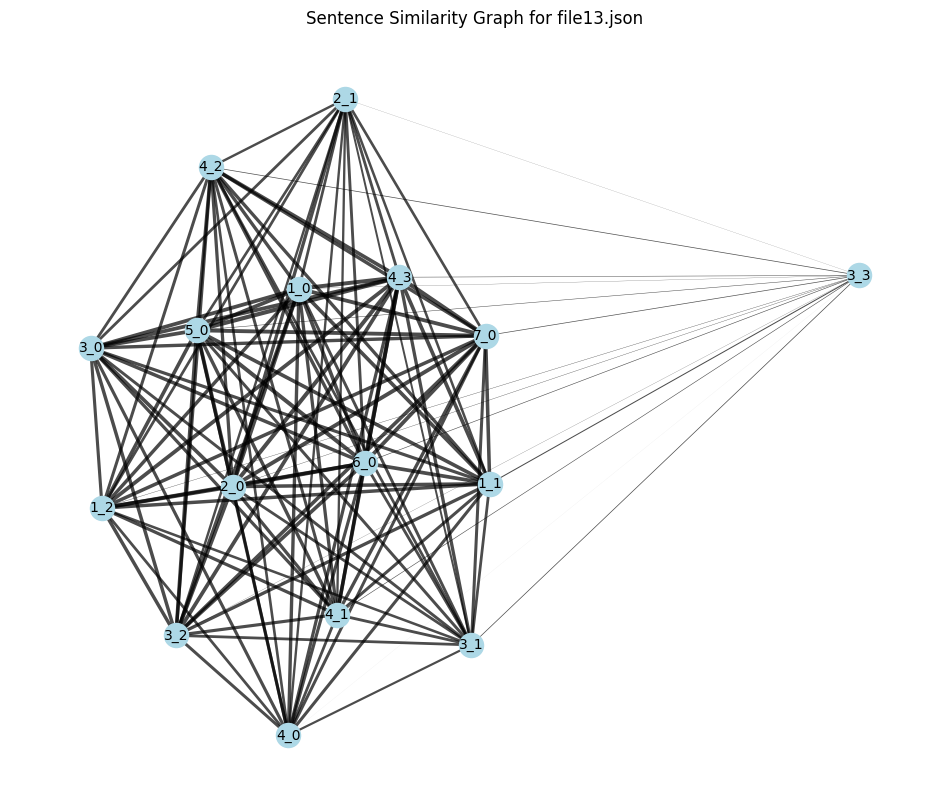

100%|██████████| 153/153 [00:04<00:00, 31.84it/s]

Successfully processed 153 files.


In [11]:
def process_file_with_fasttext(file_path, scores_folder, model):
    """
    Process a single JSON file using FastText embeddings and return the results.
    
    Args:
        file_path: Path to the JSON file to process
        scores_folder: Path to the folder containing sentence scores
        model: FastText model
    
    Returns:
        Dictionary with processing results or None if processing failed
    """
    filename = os.path.basename(file_path)
    
    # Load document data
    data = load_json_file(file_path)
    
    # Load sentence scores
    scores_path = os.path.join(scores_folder, filename)
    keyphrase_scores = {}
    if os.path.exists(scores_path):
        keyphrase_scores = load_json_file(scores_path)
    
    # Extract the title
    title_text = ""
    if '0' in data and '0' in data['0']:
        title_text = data['0']['0']
    
    # Extract sentences (skipping title)
    sentence_data = extract_sentences(data, skip_title=True)
    
    if not sentence_data:
        print(f"No sentences found in {filename} after skipping title.")
        return None
    
    # Build graph with FastText embeddings
    graph, embeddings = build_graph_with_fasttext(
        sentence_data, 
        title_text, 
        keyphrase_scores, 
        model,
    )

    if filename == print_file:
        visualize_graph(graph)
    
    return {
        'graph': graph,
        'vectors': embeddings,  # Now these are FastText embeddings
        'sentences': sentence_data,
        'title': title_text,
        'keyphrase_scores': keyphrase_scores,
        'filename': filename
    }

def process_all_files_with_fasttext(folder_path, scores_folder):
    """
    Process all JSON files in the given folder with FastText embeddings.
    
    Args:
        folder_path: Path to the folder containing document JSON files
        scores_folder: Path to the folder containing sentence scores
        
    Returns:
        Dictionary of processing results by filename
    """
    results = {}

    # Get all JSON files in the folder
    file_paths = glob.glob(os.path.join(folder_path, "*.json"))
    
    for file_path in tqdm(file_paths):
        result = process_file_with_fasttext(file_path, scores_folder, model)
        if result:
            results[result['filename']] = result
    
    return results

if __name__ == "__main__":
    documents_folder = "/kaggle/input/graduation-project/preprocessed_classical"
    scores_folder = "/kaggle/input/graduation-project/sentence_scores"
    
    # Process files with FastText
    results = process_all_files_with_fasttext(documents_folder, scores_folder)

    print(f"Successfully processed {len(results)} files.")

# 🏆 Ranking

## 🕸️ Standared Degree Centrality

In [12]:
def standard_degree_centrality(results):
    """
    Rank sentences in each file by standard degree centrality.
    
    Args:
        results: Dictionary of results from process_all_files function
        
    Returns:
        Dictionary with filename as key and list of (sentence_id, score, text) tuples as value,
        sorted by score in descending order
    """
    rankings = {}
    
    for filename, result in results.items():
        graph = result['graph']
        
        # Calculate standard degree centrality for each node
        centrality_scores = {}
        
        for node_id in graph.nodes():
            # Standard degree centrality: sum of edge weights
            centrality_score = sum(graph[node_id][neighbor]['weight'] 
                                 for neighbor in graph.neighbors(node_id))
            centrality_scores[node_id] = centrality_score
        
        # Create a list of (sentence_id, score, text) tuples
        sentence_scores = []
        for node_id, score in centrality_scores.items():
            node_data = graph.nodes[node_id]
            text = node_data['text']
            sentence_scores.append((node_id, score, text))
        
        # Sort by score in descending order
        sentence_scores.sort(key=lambda x: x[1], reverse=True)
        
        # Store rankings
        rankings[filename] = sentence_scores
    
    return rankings

## 📊🕸️ Weighted Degree Centrality

In [13]:
def weighted_centrality(results: Dict[str, Any], 
                       normalization: str = 'minmax',
                       alpha: float = 0.5,
                       use_statistical_scores: bool = True) -> Dict[str, List[Tuple[str, float, str]]]:
    """
    Rank sentences in each file by weighted degree centrality.
    
    Args:
        results: Dictionary of results from process_all_files function
        normalization: Normalization method ('minmax', 'zscore', 'none')
        alpha: Weight balance between centrality and statistical influence (0-1)
        use_statistical_scores: Whether to use statistical scores in weighting
        
    Returns:
        Dictionary with filename as key and list of (sentence_id, score, text) tuples as value,
        sorted by score in descending order
    """
    rankings = {}
    
    for filename, result in results.items():
        graph = result['graph']
        
        # Calculate weighted centrality scores
        centrality_scores = _calculate_weighted_centrality(graph, use_statistical_scores)
        
        # Normalize scores if requested
        if normalization != 'none':
            centrality_scores = _normalize_scores(centrality_scores, method=normalization)
        
        # Create a list of (sentence_id, score, text) tuples
        sentence_scores = []
        for node_id, score in centrality_scores.items():
            node_data = graph.nodes[node_id]
            text = node_data['text']
            sentence_scores.append((node_id, score, text))
        
        # Sort by score in descending order
        sentence_scores.sort(key=lambda x: x[1], reverse=True)
        rankings[filename] = sentence_scores
    
    return rankings

def _calculate_weighted_centrality(graph, use_statistical_scores: bool = True) -> Dict[str, float]:
    """
    Calculate weighted centrality using neighbor statistical scores stored in node attributes.
    
    Args:
        graph: NetworkX graph with nodes containing statistical_score attribute
        use_statistical_scores: Whether to weight by statistical scores or use simple centrality
    
    Returns:
        Dictionary mapping node_id to centrality score
    """
    centrality_scores = {}
    
    for node_id in graph.nodes():
        centrality_score = 0
        
        # Iterate through all neighbors of the node
        for neighbor in graph.neighbors(node_id):
            # Get the similarity (edge weight) between the node and its neighbor
            edge_weight = graph[node_id][neighbor]['weight']
            
            if use_statistical_scores:
                # Get the statistical score for the neighbor from node attributes
                neighbor_stat_score = graph.nodes[neighbor].get('statistical_score', 0)
                
                # Weight the edge by neighbor's statistical importance
                contribution = edge_weight * (1 + neighbor_stat_score)
            else:
                # Simple weighted degree centrality
                contribution = edge_weight
            
            centrality_score += contribution
        
        centrality_scores[node_id] = centrality_score
    
    return centrality_scores

def _normalize_scores(scores: Dict[str, float], method: str = 'minmax') -> Dict[str, float]:
    """Normalize scores using specified method."""
    if not scores:
        return scores
    
    values = list(scores.values())
    
    if method == 'minmax':
        min_val, max_val = min(values), max(values)
        if max_val == min_val:
            return {k: 0.5 for k in scores.keys()}
        return {k: (v - min_val) / (max_val - min_val) for k, v in scores.items()}
    
    elif method == 'zscore':
        mean_val = np.mean(values)
        std_val = np.std(values)
        if std_val == 0:
            return {k: 0 for k in scores.keys()}
        return {k: (v - mean_val) / std_val for k, v in scores.items()}
    
    return scores

def enhanced_weighted_centrality(results: Dict[str, Any], 
                               combination_method: str = 'multiplicative',
                               normalization: str = 'minmax') -> Dict[str, List[Tuple[str, float, str]]]:
    """
    Enhanced version that combines multiple node attributes for centrality calculation.
    
    Args:
        results: Dictionary of results from process_all_files function
        combination_method: How to combine scores ('additive', 'multiplicative', 'weighted_sum')
        normalization: Normalization method ('minmax', 'zscore', 'none')
        
    Returns:
        Dictionary with filename as key and list of (sentence_id, score, text) tuples as value
    """
    rankings = {}
    
    for filename, result in results.items():
        graph = result['graph']
        
        # Calculate enhanced centrality scores
        centrality_scores = _calculate_enhanced_centrality(graph, combination_method)
        
        # Normalize scores if requested
        if normalization != 'none':
            centrality_scores = _normalize_scores(centrality_scores, method=normalization)
        
        # Create and sort sentence scores
        sentence_scores = []
        for node_id, score in centrality_scores.items():
            node_data = graph.nodes[node_id]
            text = node_data['text']
            sentence_scores.append((node_id, score, text))
        
        sentence_scores.sort(key=lambda x: x[1], reverse=True)
        rankings[filename] = sentence_scores
    
    return rankings

def _calculate_enhanced_centrality(graph, combination_method: str = 'multiplicative') -> Dict[str, float]:
    """
    Calculate enhanced centrality using multiple node attributes.
    
    Combines:
    - Edge weights (similarity)
    - Neighbor statistical scores
    - Neighbor keyphrase scores
    - Neighbor title similarity
    """
    centrality_scores = {}
    
    for node_id in graph.nodes():
        centrality_score = 0
        
        for neighbor in graph.neighbors(node_id):
            edge_weight = graph[node_id][neighbor]['weight']
            neighbor_data = graph.nodes[neighbor]
            
            # Get neighbor attributes with defaults
            stat_score = neighbor_data.get('statistical_score', 0)
            keyphrase_score = neighbor_data.get('keyphrase_score', 0)
            title_sim = neighbor_data.get('title_similarity', 0)
            
            # Combine scores based on method
            if combination_method == 'additive':
                neighbor_importance = stat_score + keyphrase_score + title_sim
            elif combination_method == 'multiplicative':
                # Add 1 to avoid zero multiplication
                neighbor_importance = (1 + stat_score) * (1 + keyphrase_score) * (1 + title_sim)
            elif combination_method == 'weighted_sum':
                # Weighted combination (you can adjust weights)
                neighbor_importance = (0.5 * stat_score + 0.3 * keyphrase_score + 0.2 * title_sim)
            else:
                neighbor_importance = stat_score  # Default to statistical score only
            
            contribution = edge_weight * neighbor_importance
            centrality_score += contribution
        
        centrality_scores[node_id] = centrality_score
    
    return centrality_scores

# Utility functions for analysis
def analyze_centrality_distribution(rankings: Dict[str, List[Tuple[str, float, str]]]) -> Dict[str, Dict]:
    """Analyze the distribution of centrality scores across files."""
    analysis = {}
    
    for filename, sentence_scores in rankings.items():
        scores = [score for _, score, _ in sentence_scores]
        
        analysis[filename] = {
            'mean': np.mean(scores) if scores else 0,
            'std': np.std(scores) if scores else 0,
            'min': min(scores) if scores else 0,
            'max': max(scores) if scores else 0,
            'median': np.median(scores) if scores else 0,
            'top_10_percent_threshold': np.percentile(scores, 90) if scores else 0,
            'num_sentences': len(scores)
        }
    
    return analysis

## Compute Adaptive Alpha 🔧

In [14]:
def calculate_adaptive_alpha(normalized_textrank, normalized_other,method, min_alpha=0.1, max_alpha=0.9):
    """
    Calculate an adaptive alpha value based on the quality and distribution of TextRank vs other scores.
    
    Args:
        normalized_textrank: Array of normalized TextRank scores
        normalized_other: Array of normalized other feature scores
        method: Method to use for alpha calculation
                'variance_ratio' - Based on relative variance (default)
                'entropy_ratio' - Based on information entropy
                'correlation' - Based on negative correlation
                'combined' - Weighted combination of multiple metrics
        min_alpha: Minimum allowed alpha value (default=0.1)
        max_alpha: Maximum allowed alpha value (default=0.9)
    
    Returns:
        float: Adaptive alpha value between min_alpha and max_alpha
    """
    
    if len(normalized_textrank) != len(normalized_other):
        raise ValueError("TextRank and other scores must have the same length")
    
    if len(normalized_textrank) == 0:
        return 0.5  # Default for empty arrays
    
    if method == 'variance_ratio':
        return _alpha_by_variance_ratio(normalized_textrank, normalized_other, min_alpha, max_alpha)
    
    elif method == 'entropy_ratio':
        return _alpha_by_entropy_ratio(normalized_textrank, normalized_other, min_alpha, max_alpha)
    
    elif method == 'correlation':
        return _alpha_by_correlation(normalized_textrank, normalized_other, min_alpha, max_alpha)
    
    elif method == 'combined':
        return _alpha_by_combined_metrics(normalized_textrank, normalized_other, min_alpha, max_alpha)
    
    else:
        raise ValueError(f"Unknown method: {method}")


def _alpha_by_variance_ratio(textrank_scores, other_scores, min_alpha, max_alpha):
    """
    Calculate alpha based on variance ratio.
    Higher variance indicates more discriminative power.
    """
    var_textrank = np.var(textrank_scores)
    var_other = np.var(other_scores)
    
    # Avoid division by zero
    total_var = var_textrank + var_other
    if total_var < 1e-10:
        return 0.5
    
    # Alpha proportional to TextRank's relative variance
    alpha = var_textrank / total_var
    return np.clip(alpha, min_alpha, max_alpha)


def _alpha_by_entropy_ratio(textrank_scores, other_scores, min_alpha, max_alpha):
    """
    Calculate alpha based on entropy ratio.
    Higher entropy indicates more information content.
    """
    # Convert scores to probability distributions
    textrank_probs = textrank_scores / (np.sum(textrank_scores) + 1e-10)
    other_probs = other_scores / (np.sum(other_scores) + 1e-10)
    
    # Calculate entropy (add small epsilon to avoid log(0))
    entropy_textrank = entropy(textrank_probs + 1e-10)
    entropy_other = entropy(other_probs + 1e-10)
    
    total_entropy = entropy_textrank + entropy_other
    if total_entropy < 1e-10:
        return 0.5
    
    # Alpha proportional to TextRank's relative entropy
    alpha = entropy_textrank / total_entropy
    return np.clip(alpha, min_alpha, max_alpha)


def _alpha_by_correlation(textrank_scores, other_scores, min_alpha, max_alpha):
    """
    Calculate alpha based on negative correlation.
    If scores are highly correlated, balance them equally.
    If uncorrelated, favor the one with higher variance.
    """
    if len(textrank_scores) < 2:
        return 0.5
    
    # Calculate correlation coefficient
    correlation = np.corrcoef(textrank_scores, other_scores)[0, 1]
    
    # Handle NaN correlation (constant arrays)
    if np.isnan(correlation):
        correlation = 1.0
    
    # Convert correlation to alpha
    # High correlation (close to 1) -> alpha closer to 0.5
    # Low correlation (close to 0) -> favor higher variance method
    correlation_factor = abs(correlation)
    
    if correlation_factor > 0.8:  # Highly correlated
        alpha = 0.5
    else:
        # Use variance ratio for uncorrelated scores
        var_textrank = np.var(textrank_scores)
        var_other = np.var(other_scores)
        total_var = var_textrank + var_other
        
        if total_var < 1e-10:
            alpha = 0.5
        else:
            alpha = var_textrank / total_var
            # Adjust based on correlation - less correlated means more trust in variance
            alpha = 0.5 + (alpha - 0.5) * (1 - correlation_factor)
    
    return np.clip(alpha, min_alpha, max_alpha)


def _alpha_by_combined_metrics(textrank_scores, other_scores, min_alpha, max_alpha):
    """
    Calculate alpha using a weighted combination of multiple metrics.
    """
    # Get individual alphas
    alpha_var = _alpha_by_variance_ratio(textrank_scores, other_scores, 0, 1)
    alpha_entropy = _alpha_by_entropy_ratio(textrank_scores, other_scores, 0, 1)
    alpha_corr = _alpha_by_correlation(textrank_scores, other_scores, 0, 1)
    
    # Weighted combination (you can adjust these weights)
    weights = [0.4, 0.3, 0.3]  # [variance, entropy, correlation]
    alpha = (weights[0] * alpha_var + 
             weights[1] * alpha_entropy + 
             weights[2] * alpha_corr)
    
    return np.clip(alpha, min_alpha, max_alpha)


# Helper function to analyze score quality for debugging
def analyze_score_quality(textrank_scores, other_scores, filename):
    """
    Analyze the quality metrics of both score sets for debugging purposes.
    """
    print(f"\n--- Score Analysis for {filename} ---")
    print(f"TextRank - Mean: {np.mean(textrank_scores):.4f}, Var: {np.var(textrank_scores):.4f}")
    print(f"Other    - Mean: {np.mean(other_scores):.4f}, Var: {np.var(other_scores):.4f}")
    
    if len(textrank_scores) > 1:
        correlation = np.corrcoef(textrank_scores, other_scores)[0, 1]
        if not np.isnan(correlation):
            print(f"Correlation: {correlation:.4f}")
    
    # Calculate adaptive alphas for different methods
    methods = ['variance_ratio', 'entropy_ratio', 'correlation', 'combined']
    for method in methods:
        alpha = calculate_adaptive_alpha(textrank_scores, other_scores, method=method)
        print(f"Alpha ({method}): {alpha:.4f}")

## 📊 Statistical TextRank
### This function uses TextRank with initial scores = lenght + pos + cue + nuarical

In [15]:
def statistical_TextRank(results, damping=0.85):
    """
    Implements TextRank algorithm for sentence ranking where:
    1. Initial scores are based on statistical scores of sentences
    2. Final scores are pure TextRank scores (no weighted combination)
    
    Args:
        results: Dictionary of processing results by filename
        damping: Damping factor for TextRank (default=0.85)
        max_iterations: Maximum number of iterations (default=100)
        
    Returns:
        Dictionary of rankings by filename
    """
    rankings = {}
    scores_dir = "/kaggle/input/graduation-project/sentence_scores"
    
    for filename, result in results.items():
        graph = result['graph']
        sentences = result['sentences']
        
        base_filename = os.path.splitext(os.path.basename(filename))[0]
        scores_path = os.path.join(scores_dir, f"{base_filename}.json")
        
        try:
            statistical_scores = load_json_file(scores_path)
        except FileNotFoundError:
            print(f"Warning: Statistical scores file not found for {filename}. Using default scores.")
            statistical_scores = {}
            
        nodes = list(graph.nodes())
        node_to_idx = {node: i for i, node in enumerate(nodes)}
        n = len(nodes)
        
        if n == 0:
            rankings[filename] = []
            continue
            
        # Initialize TextRank scores with statistical scores instead of 1/N
        scores = np.zeros(n)
        for i, node in enumerate(nodes):
            node_data = graph.nodes[node]
            para_idx = node_data['para_idx']
            sent_idx = node_data['sent_idx']
            stat_score = statistical_scores.get(str(para_idx), {}).get(str(sent_idx), {}).get('statistical_score', 0)
            scores[i] = max(stat_score, 0.01)  # Ensure minimum score of 0.01 to avoid zeros
            
        # Normalize initial scores
        if np.sum(scores) > 0:
            scores = scores / np.sum(scores)
        else:
            # Fallback to uniform distribution if all stats are zero
            scores = np.ones(n) / n
        
        # Precompute outgoing weights
        out_weights_sum = {}
        for node in nodes:
            out_sum = sum(graph[node][nbr]['weight'] for nbr in graph.neighbors(node))
            out_weights_sum[node] = max(out_sum, 1e-10)  # Avoid division by zero
        
        # Run TextRank iterations
        converged = False
        for iteration in range(1, max_iterations + 1):
            new_scores = np.ones(n) * (1 - damping)
            for i, node_i in enumerate(nodes):
                score_sum = 0
                for neighbor in graph.neighbors(node_i):
                    j = node_to_idx[neighbor]
                    weight = graph[node_i][neighbor]['weight']
                    norm_factor = np.sqrt(out_weights_sum[node_i] * out_weights_sum[neighbor])
                    score_sum += (weight * scores[j]) / norm_factor
                new_scores[i] += damping * score_sum
                
            if np.allclose(scores, new_scores, atol=1e-6):
                print(f"Converged after {iteration} iterations for file: {filename}")
                converged = True
                break
                
            scores = new_scores
        
        if not converged:
            print(f"⚠️ Warning: TextRank did NOT converge after {max_iterations} iterations for file: {filename}")

        # Normalize final scores
        if np.max(scores) > np.min(scores):
            normalized_scores = (scores - np.min(scores)) / (np.max(scores) - np.min(scores))
        else:
            normalized_scores = np.ones(n) / n
            
        # For debugging - can be removed for production
        if 'print_file' in globals() and filename == print_file:
            for i, node in enumerate(nodes):
                node_data = graph.nodes[node]
                para_idx = node_data['para_idx']
                sent_idx = node_data['sent_idx']
                print(f"  Sentence [{para_idx}][{sent_idx}]:")
                print(f"    TextRank score:   {normalized_scores[i]:.4f}")
        
        # Store results
        sentence_scores = [
            (node, float(normalized_scores[i]), graph.nodes[node]['text']) 
            for i, node in enumerate(nodes)
        ]
        sentence_scores.sort(key=lambda x: x[1], reverse=True)
        rankings[filename] = sentence_scores
    
    return rankings

## 🔗 fusion TextRank
### score = alpha * TextRank_score + (1 - alpha) * statistical_score

In [16]:
def fusion_TextRank(results, damping=0.85):
    global alpha
    rankings = {}
    scores_dir = "/kaggle/input/graduation-project/sentence_scores"
    
    for filename, result in results.items():
        #print(f"\nProcessing file: {print_file}")
        graph = result['graph']
        sentences = result['sentences']
        
        base_filename = os.path.splitext(os.path.basename(filename))[0]
        scores_path = os.path.join(scores_dir, f"{base_filename}.json")
        
        try:
            statistical_scores = load_json_file(scores_path)
        except FileNotFoundError:
            print(f"Warning: Statistical scores file not found for {filename}. Using default scores.")
            statistical_scores = {}
        nodes = list(graph.nodes())
        node_to_idx = {node: i for i, node in enumerate(nodes)}
        n = len(nodes)
        
        if n == 0:
            rankings[filename] = []
            continue
        # Initialize TextRank scores: 1/N
        scores = np.ones(n) / n 
        
        # Precompute outgoing weights
        out_weights_sum = {}
        for node in nodes:
            out_sum = sum(graph[node][nbr]['weight'] for nbr in graph.neighbors(node))
            out_weights_sum[node] = max(out_sum, 1e-10)
        
        # Run TextRank iterations
        converged = False
        for iteration in range(1, max_iterations + 1):
            new_scores = np.ones(n) * (1 - damping)
            for i, node_i in enumerate(nodes):
                score_sum = 0
                for neighbor in graph.neighbors(node_i):
                    j = node_to_idx[neighbor]
                    weight = graph[node_i][neighbor]['weight']
                    norm_factor = np.sqrt(out_weights_sum[node_i] * out_weights_sum[neighbor])
                    score_sum += (weight * scores[j]) / norm_factor
                new_scores[i] += damping * score_sum
            if np.allclose(scores, new_scores, atol=1e-6):
                print(f"Converged after {iteration} iterations for file: {filename}")
                converged = True
                break
            scores = new_scores
        
        if not converged:
            print(f"⚠️ Warning: TextRank did NOT converge after {max_iterations} iterations for file: {filename}")

        # Collect raw scores (TextRank and stat)
        raw_textrank_scores = scores.copy()
        raw_stat_scores = np.zeros(n)
        for i, node in enumerate(nodes):
            node_data = graph.nodes[node]
            para_idx = node_data['para_idx']
            sent_idx = node_data['sent_idx']
            stat_score = statistical_scores.get(para_idx, {}).get(sent_idx, {}).get('statistical_score', 0)
            raw_stat_scores[i] = stat_score 
        # Normalize both using same min and max
        combined_min = min(np.min(raw_textrank_scores), np.min(raw_stat_scores))
        combined_max = max(np.max(raw_textrank_scores), np.max(raw_stat_scores))
        combined_range = max(combined_max - combined_min, 1e-10)
        normalized_textrank = (raw_textrank_scores - combined_min) / combined_range
        normalized_stat = (raw_stat_scores - combined_min) / combined_range
        # Combine scores
        if alpha_method != "":
            alpha = calculate_adaptive_alpha(normalized_textrank, normalized_stat, alpha_method)
        final_scores = alpha * normalized_textrank + (1 - alpha) * normalized_stat
        
        # Print scores
        for i, node in enumerate(nodes):
            node_data = graph.nodes[node]
            para_idx = node_data['para_idx']
            sent_idx = node_data['sent_idx']
            if filename == print_file:
                print(f"  Sentence [{para_idx}][{sent_idx}]:")
                print(f"    TextRank score:   {normalized_textrank[i]:.4f}")
                print(f"    Stat score:       {normalized_stat[i]:.4f}")
                print(f"    Final score:      {final_scores[i]:.4f}")
        # Store results
        sentence_scores = [
            (node, float(final_scores[i]), graph.nodes[node]['text']) for i, node in enumerate(nodes)
        ]
        sentence_scores.sort(key=lambda x: x[1], reverse=True)
        rankings[filename] = sentence_scores
    
    return rankings

## ⚙️ Hybrid TextRank
### final_score = alpha * TextRank_score + (1 - alpha) * (statistical_Score + keyphrase_Score + title_similarity)

In [17]:
def hybrid_TextRank(results, damping=0.85):
    """
    Implements a hybrid TextRank algorithm with global normalization:
    1. Initial scores are standard 1/N
    2. Both TextRank and other scores are normalized using global min/max
    3. Final scores combine TextRank with multiple other feature scores
    
    Args:
        results: Dictionary of processing results by filename
        damping: Damping factor for TextRank (default=0.85)
        max_iterations: Maximum number of iterations (default=100)
        alpha: Weight for TextRank score in final combination (default=0.5)
        
    Returns:
        Dictionary of rankings by filename
    """
    global alpha
    rankings = {}
    
    for filename, result in results.items():
        graph = result['graph']
        sentences = result['sentences']
            
        nodes = list(graph.nodes())
        node_to_idx = {node: i for i, node in enumerate(nodes)}
        n = len(nodes)
        
        if n == 0:
            rankings[filename] = []
            continue
            
        # Initialize TextRank scores with standard 1/N
        scores = np.ones(n) / n
        
        # Precompute outgoing weights
        out_weights_sum = {}
        for node in nodes:
            out_sum = sum(graph[node][nbr]['weight'] for nbr in graph.neighbors(node))
            out_weights_sum[node] = max(out_sum, 1e-10)  # Avoid division by zero
        
        # Run TextRank iterations
        converged = False
        for iteration in range(1, max_iterations + 1):
            new_scores = np.ones(n) * (1 - damping)
            for i, node_i in enumerate(nodes):
                score_sum = 0
                for neighbor in graph.neighbors(node_i):
                    j = node_to_idx[neighbor]
                    weight = graph[node_i][neighbor]['weight']
                    norm_factor = np.sqrt(out_weights_sum[node_i] * out_weights_sum[neighbor])
                    score_sum += (weight * scores[j]) / norm_factor
                new_scores[i] += damping * score_sum
                
            if np.allclose(scores, new_scores, atol=1e-6):
                print(f"Converged after {iteration} iterations for file: {filename}")
                converged = True
                break
                
            scores = new_scores
        
        if not converged:
            print(f"⚠️ Warning: TextRank did NOT converge after {max_iterations} iterations for file: {filename}")

        # Get raw TextRank scores
        raw_textrank_scores = scores.copy()
        
        # Calculate combined other scores (statistical + keyphrase + title_similarity)
        raw_other_scores = np.zeros(n)
        for i, node in enumerate(nodes):
            node_data = graph.nodes[node]
            
            # Get all component scores from node attributes
            stat_score = node_data.get('statistical_score', 0)
            keyphrase_score = node_data.get('keyphrase_score', 0)
            title_similarity = node_data.get('title_similarity', 0)
            
            # Combine them
            raw_other_scores[i] = stat_score + keyphrase_score + title_similarity
        
        # Find global min and max across both score types
        global_min = min(np.min(raw_textrank_scores), np.min(raw_other_scores))
        global_max = max(np.max(raw_textrank_scores), np.max(raw_other_scores))
        
        # Normalize both sets of scores using global min/max
        if global_max > global_min:
            normalized_textrank = (raw_textrank_scores - global_min) / (global_max - global_min)
            normalized_other = (raw_other_scores - global_min) / (global_max - global_min)
        else:
            # If all scores are identical, use sensible defaults
            normalized_textrank = np.ones(n) / n
            normalized_other = np.ones(n) / n
        
        # Combine scores using alpha
        if alpha_method != "":
            alpha = calculate_adaptive_alpha(normalized_textrank, normalized_other, alpha_method)
        final_scores = alpha * normalized_textrank + (1 - alpha) *  normalized_other
        #_alpha_by_combined_metrics(normalized_textrank, , min_alpha, max_alpha):
        
        # For debugging - can be removed for production
        if 'print_file' in globals() and filename == print_file:
            for i, node in enumerate(nodes):
                node_data = graph.nodes[node]
                para_idx = node_data['para_idx']
                sent_idx = node_data['sent_idx']
                
                # Get individual components for debugging display
                stat_score = node_data.get('statistical_score', 0)
                keyphrase_score = node_data.get('keyphrase_score', 0)
                title_similarity = node_data.get('title_similarity', 0)
                
                print(f"  Sentence [{para_idx}][{sent_idx}]:")
                #print(f"    TextRank raw:      {raw_textrank_scores[i]:.4f}")
                #print(f"    Other raw:         {raw_other_scores[i]:.4f}")
                #print(f"    Global min/max:    {global_min:.4f}/{global_max:.4f}")
                print(f"    TextRank norm:     {normalized_textrank[i]:.4f}")
                print(f"    Other norm:        {normalized_other[i]:.4f}")
                print(f"    Final score:       {final_scores[i]:.4f}")
                print(f"    Components: [Stat: {stat_score:.4f}, Keyphrase: {keyphrase_score:.4f}, Title: {title_similarity:.4f}]")
        
        # Store results
        sentence_scores = [
            (node, float(final_scores[i]), graph.nodes[node]['text']) 
            for i, node in enumerate(nodes)
        ]
        sentence_scores.sort(key=lambda x: x[1], reverse=True)
        rankings[filename] = sentence_scores
    
    return rankings

## 📄🕸️ PageRank

In [18]:
def pagerank(results):
    """
    Rank sentences in each file by TextRank algorithm.
    
    Args:
        results: Dictionary of results from process_all_files function
        max_iterations: (global variable) Maximum number of iterations for PageRank algorithm
        
    Returns:
        Dictionary with filename as key and list of (sentence_id, score, text) tuples as value,
        sorted by score in descending order
    """
    rankings = {}
    
    for filename, result in results.items():
        graph = result['graph']
        sentences = result['sentences']
        
        # Calculate TextRank scores (PageRank) for each node with max iterations
        pagerank_scores = nx.pagerank(graph, max_iter=max_iterations)
        
        # Create a list of (sentence_id, score, text) tuples
        sentence_scores = []
        for node_id, score in pagerank_scores.items():
            # Get node data
            node_data = graph.nodes[node_id]
            para_idx = node_data['para_idx']
            sent_idx = node_data['sent_idx']
            text = node_data['text']
            
            sentence_scores.append((node_id, score, text))
        
        # Sort by score in descending order
        sentence_scores.sort(key=lambda x: x[1], reverse=True)
        
        # Store rankings
        rankings[filename] = sentence_scores
        
        # Optional: Calculate some statistics about the scores
        scores = [score for _, score, _ in sentence_scores]
    
    return rankings

In [19]:
if(ranking_method == 1): 
    rankings = standard_degree_centrality(results)
elif(ranking_method == 2):
    rankings = weighted_centrality(results)
elif(ranking_method == 3):
    rankings = enhanced_weighted_centrality(results)
elif(ranking_method == 4):
    rankings = statistical_TextRank(results)
elif(ranking_method == 5):
    rankings = fusion_TextRank(results)
elif(ranking_method == 6):
    rankings = hybrid_TextRank(results)
elif(ranking_method == 7):
    rankings = pagerank(results)

Converged after 60 iterations for file: file143.json
Converged after 60 iterations for file: file123.json
Converged after 60 iterations for file: file102.json
Converged after 60 iterations for file: file129.json
Converged after 60 iterations for file: file134.json
Converged after 60 iterations for file: file50.json
Converged after 60 iterations for file: file150.json
Converged after 60 iterations for file: file25.json
Converged after 60 iterations for file: file107.json
Converged after 60 iterations for file: file42.json
Converged after 58 iterations for file: file34.json
Converged after 60 iterations for file: file31.json
Converged after 61 iterations for file: file122.json
Converged after 60 iterations for file: file148.json
Converged after 59 iterations for file: file40.json
Converged after 60 iterations for file: file61.json
Converged after 60 iterations for file: file151.json
Converged after 61 iterations for file: file11.json
Converged after 60 iterations for file: file82.json
Co

# ✂️ Sentence Selection

In [20]:
def sentence_selection(rankings, file_results, original_folder, summaries_sizes=sumaries_sizes):
    """
    Generate extractive summaries for each file by selecting top sentences from original files.
    Uses the number of sentences found in the voted folder as the target number of sentences.
    Avoids redundant sentences by checking similarity with already selected sentences.
    
    Args:
        rankings: The output from rank_sentences_by_centrality
        file_results: Original results from process_all_files
        original_folder: Path to folder containing original sentences
        summaries_sizes: Dictionary with filename as key and target sentence count as value
        with_redundancy_reduction: Whether to perform redundancy reduction
        redundancy_threshold: Maximum allowed similarity between sentences in summary (0.0 to 1.0)
        
    Returns:
        Dictionary with filename as key and summary text as value
    """
    summaries = {}
    
    for filename, ranked_sentences in rankings.items():
        # Load original sentences file
        original_file_path = os.path.join(original_folder, filename)
        try:
            with open(original_file_path, 'r', encoding='utf-8') as f:
                original_data = json.load(f)
        except FileNotFoundError:
            print(f"Warning: Original file {filename} not found in {original_folder}")
            continue
        
        # Count total sentences in original file
        total_sentences = sum(len(original_data.get(para, {})) for para in original_data)
        
        # Skip the title if present (assuming title is in paragraph "0" with a single sentence "0")
        has_title = False
        if "0" in original_data and len(original_data["0"]) == 1 and "0" in original_data["0"]:
            total_sentences -= 1
            has_title = True
        
        # Get the target number of sentences from summaries_sizes dictionary
        base_filename = filename
        
        # Check if this file exists in summaries_sizes
        if base_filename not in summaries_sizes:
            print(f"Warning: No target size found for {base_filename} in summaries_sizes")
            # Skip this file by setting an empty summary and continuing to the next file
            summaries[filename] = ""
            continue
            
        # Get the target sentence count from summaries_sizes
        target_sentences = summaries_sizes[base_filename]
        
        # Original graph to get paragraph and sentence indices and TF-ISF vectors
        graph = file_results[filename]['graph']
        vectors = file_results[filename]['vectors']
        
        # Keep track of selected sentences and their TF-ISF vectors
        selected_sentences = []
        selected_vectors = []
        
        # Process ranked sentences in order
        for sent_id, score, *_ in ranked_sentences:
            # Skip once we've reached our target number of sentences
            if len(selected_sentences) >= target_sentences:
                break
                
            # Parse sentence ID to get paragraph and sentence indices
            para_idx, sent_idx = sent_id.split('_')
            
            # Skip title if identified (assuming paragraph 0, sentence 0 is title)
            if has_title and para_idx == "0" and sent_idx == "0":
                continue
                
            # Get the TF-ISF vector for this sentence
            vector_idx = graph.nodes[sent_id]['vector_idx']
            current_vector = vectors[vector_idx]
            
            if with_redundancy_reduction:
                # Check if this sentence is redundant compared to already selected sentences
                is_redundant = False
                for sel_vector in selected_vectors:
                    similarity = cosine_similarity(current_vector, sel_vector)
                    if similarity > redundancy_threshold:
                        is_redundant = True
                        break
            
                # Skip redundant sentences
                if is_redundant:
                    continue
            
            # Extract original sentence from the original data
            try:
                original_text = original_data[para_idx][sent_idx]
                selected_sentences.append((int(para_idx), int(sent_idx), original_text))
                selected_vectors.append(current_vector)
            except KeyError:
                print(f"Warning: Sentence ID {sent_id} not found in original file {filename}")
                continue
        
        # Sort by paragraph index first, then sentence index for proper document flow
        selected_sentences.sort()
        
        # Combine sentences into summary
        summary = ". ".join([text for _, _, text in selected_sentences])
        summaries[filename] = summary
        
        if filename == print_file:
            print(f"\nExtractive summary for {filename} ({len(selected_sentences)} of {total_sentences} sentences, {round(len(selected_sentences)/total_sentences*100, 1)}%):")
            print(f"Target sentences from voted folder: {target_sentences}")
            print(summary)
    
    return summaries

In [21]:
# Path to original sentences
original_folder = "/kaggle/input/graduation-project/original_sentences"
    
summaries = sentence_selection(
    rankings, 
    results, 
    original_folder, 
)


Extractive summary for file13.json (4 of 16 sentences, 25.0%):
Target sentences from voted folder: 4
يشكل الإصلاح  في العالم العربي أحد أهم محاور المنتدى الاقتصادي العالمي الذي يتخلى عن نخبويته لأول مرة ليرتكز في حوارا ته حوله إلى استطلاعات رأي تخاطب نبض الشارع العربي من محيطه إلى خليجة. في الأردن ثمة ورشة حوارية دائرة في الجامعات وفي الصحافة ومؤسسات المجتمع المدني هدفها إشراك المجتمع على اختلاف شرائحه لبناء خزان افكار حول عملية الإصلاح بمفهومه الشامل الذي يحتاج لان يبنى  على أرضية صلبة ومؤسسية بشراكة الجميع بقناعة بان نتاج  كل هذا الجهد انما هي مصلحة للجميع وبان أي تعثر انما هو مسؤولية وضرر للجميع. ان التعليم وحده هو الذي يحدث الفرق عندما تحرز ثقافة المجتمع تطورا ملموسا وتترسخ مبادىء تكافؤ الفرص بفضله  لقد عزز الملك اتجاهات الاصلاح والتحديث باشراف منه ومتابعة حثيثة عبر برنامج احالها الى استراتيجية تتصدى لها الحكومات المتعاقبة بمعزل عن التوتر الاقليمي فقد  قرر ان لا يتريث كما فعل غيره وان لا ينتظر الى ان يحدث الاستقرار السياسي في المنطقة  على اهميته للبدء بالاصلاحات و نتائج البداية ال

# ⚖️ Evaluation

In [22]:
def evaluate_summaries_with_rouge(generated_summaries, reference_folder):
    """
    Evaluate generated summaries against reference summaries using ROUGE metrics.
    
    Args:
        generated_summaries: Dictionary with filename as key and generated summary as value
        reference_folder: Path to folder containing reference summaries
        
    Returns:
        Dictionary with average ROUGE scores and per-file scores
    """
    # Initialize Rouge calculator
    rouge = Rouge()
    
    # Store all scores
    all_scores = {}
    
    # Store aggregate scores for averaging
    aggregate_scores = {
        'rouge-1': {'f': [], 'p': [], 'r': []},
        'rouge-2': {'f': [], 'p': [], 'r': []},
        'rouge-l': {'f': [], 'p': [], 'r': []}
    }
    
    # Get list of all reference files
    reference_files = os.listdir(reference_folder)

    
    # Evaluate each generated summary against its reference summaries
    for filename, generated_summary in generated_summaries.items():
        # Extract base filename without extension
        base_filename = os.path.splitext(filename)[0]
        
        # Find all reference summaries for this file
        file_refs = [f for f in reference_files if f.startswith(f"{base_filename}_sum")]
        
        if not file_refs:
            print(f"Warning: No reference summaries found for {filename}. Skipping this file.")
            continue
        
        # Load all reference summaries for this file
        valid_reference_summaries = []
        for ref_file in file_refs:
            ref_path = os.path.join(reference_folder, ref_file)
            try:
                with open(ref_path, 'r', encoding='utf-8') as f:
                    ref_content = f.read().strip()
                    # Check if reference summary is empty or only has one sentence
                    if not ref_content:
                        print(f"Warning: Empty reference file {ref_file}. Ignoring this reference.")
                        continue
                    
                    # Count sentences (naive approach - split by period, exclamation mark, or question mark)
                    sentences = re.split(r'[.!?]+', ref_content)
                    sentences = [s.strip() for s in sentences if s.strip()]
                    
                    #if len(sentences) <= 1:
                    #    print(f"Warning: Reference file {ref_file} has only one sentence. Ignoring this reference.")
                    #    continue
                    
                    valid_reference_summaries.append(ref_content)
            except Exception as e:
                print(f"Error reading reference file {ref_file}: {e}")
                continue
        
        if not valid_reference_summaries:
            print(f"Warning: No valid reference summaries for {filename}. Skipping this file.")
            continue
        
        # Calculate ROUGE scores against each reference
        file_scores = {
            'rouge-1': {'f': [], 'p': [], 'r': []},
            'rouge-2': {'f': [], 'p': [], 'r': []},
            'rouge-l': {'f': [], 'p': [], 'r': []}
        }
        
        for ref_summary in valid_reference_summaries:
            try:
                # Make sure generated summary is not empty
                if not generated_summary.strip():
                    print(f"Warning: Empty generated summary for {filename}. Skipping this file.")
                    continue
                    
                # Calculate ROUGE scores
                scores = rouge.get_scores(generated_summary, ref_summary)[0]
                
                # Add scores to file-specific records
                for metric in ['rouge-1', 'rouge-2', 'rouge-l']:
                    for score_type in ['f', 'p', 'r']:
                        file_scores[metric][score_type].append(scores[metric][score_type])
            except Exception as e:
                print(f"Error calculating ROUGE for {filename} with a reference: {e}")
                continue
        
        # Skip this file if no valid scores were calculated
        if not any(file_scores[metric][score_type] for metric in ['rouge-1', 'rouge-2', 'rouge-l'] for score_type in ['f', 'p', 'r']):
            print(f"Warning: Could not calculate any valid ROUGE scores for {filename}. Skipping this file.")
            continue
            
        # Calculate average score across all references for this file
        file_avg_scores = {}
        for metric in ['rouge-1', 'rouge-2', 'rouge-l']:
            file_avg_scores[metric] = {}
            for score_type in ['f', 'p', 'r']:
                if file_scores[metric][score_type]:
                    score_avg = np.mean(file_scores[metric][score_type])
                    file_avg_scores[metric][score_type] = score_avg
                    
                    # Add to aggregate scores for overall average
                    aggregate_scores[metric][score_type].append(score_avg)
                else:
                    file_avg_scores[metric][score_type] = 0.0
        
        # Store file scores
        all_scores[filename] = file_avg_scores
        
        # Print summary for this file with precision and recall
        print(f"\nROUGE scores for {filename}:")
        print(f"  ROUGE-1: F1: {file_avg_scores['rouge-1']['f']:.4f}, Precision: {file_avg_scores['rouge-1']['p']:.4f}, Recall: {file_avg_scores['rouge-1']['r']:.4f}")
        print(f"  ROUGE-2: F1: {file_avg_scores['rouge-2']['f']:.4f}, Precision: {file_avg_scores['rouge-2']['p']:.4f}, Recall: {file_avg_scores['rouge-2']['r']:.4f}")
        print(f"  ROUGE-L: F1: {file_avg_scores['rouge-l']['f']:.4f}, Precision: {file_avg_scores['rouge-l']['p']:.4f}, Recall: {file_avg_scores['rouge-l']['r']:.4f}")
    
    # Calculate overall average scores
    average_scores = {}
    for metric in ['rouge-1', 'rouge-2', 'rouge-l']:
        average_scores[metric] = {}
        for score_type in ['f', 'p', 'r']:
            if aggregate_scores[metric][score_type]:
                average_scores[metric][score_type] = np.mean(aggregate_scores[metric][score_type])
            else:
                average_scores[metric][score_type] = 0.0
    
    # Print number of files used in evaluation
    evaluated_files_count = len(all_scores)
    total_files_count = len(generated_summaries)
    print(f"\nEvaluated {evaluated_files_count} out of {total_files_count} files.")
    
    # Print overall summary with precision and recall
    print("\n" + "="*60)
    print("OVERALL AVERAGE ROUGE SCORES:")
    print(f"  ROUGE-1: F1: {average_scores['rouge-1']['f']:.4f}, Precision: {average_scores['rouge-1']['p']:.4f}, Recall: {average_scores['rouge-1']['r']:.4f}")
    print(f"  ROUGE-2: F1: {average_scores['rouge-2']['f']:.4f}, Precision: {average_scores['rouge-2']['p']:.4f}, Recall: {average_scores['rouge-2']['r']:.4f}")
    print(f"  ROUGE-L: F1: {average_scores['rouge-l']['f']:.4f}, Precision: {average_scores['rouge-l']['p']:.4f}, Recall: {average_scores['rouge-l']['r']:.4f}")
    print("="*60)
    
    return {
        'average': average_scores,
        'per_file': all_scores,
        'evaluated_files_count': evaluated_files_count,
        'total_files_count': total_files_count
    }

# Example usage
if __name__ == "__main__":
    # Reference summaries folder path
    reference_folder = "/kaggle/input/voted-sentences"
    
    # Assuming 'summaries' is the variable containing our generated summaries
    # from the previous extractive summarization step
    evaluation_results = evaluate_summaries_with_rouge(summaries, reference_folder)
    
    # Additional analysis: Find best and worst performing files
    per_file_scores = evaluation_results['per_file']
    
    # Get scores for ROUGE-1
    file_metrics = [(filename, scores['rouge-1']['f'], scores['rouge-1']['p'], scores['rouge-1']['r']) 
                   for filename, scores in per_file_scores.items()]
    
    # Sort by F1 score
    f1_scores = [(filename, f1) for filename, f1, p, r in file_metrics]
    f1_scores.sort(key=lambda x: x[1])
    
    # Sort by precision
    precision_scores = [(filename, p) for filename, _, p, _ in file_metrics]
    precision_scores.sort(key=lambda x: x[1])
    
    # Sort by recall
    recall_scores = [(filename, r) for filename, _, _, r in file_metrics]
    recall_scores.sort(key=lambda x: x[1])
    
    print("\nFILE PERFORMANCE ANALYSIS:")
    
    # Check if we have enough files to show stats
    worst_count = min(3, len(f1_scores))
    best_count = min(3, len(f1_scores))
    
    # F1 Score Analysis
    if worst_count > 0:
        print("\nWorst performing files (ROUGE-1 F1):")
        for filename, score in f1_scores[:worst_count]:  # Bottom 3 or fewer
            print(f"  {filename}: {score:.4f}")
    
    if best_count > 0:        
        print("\nBest performing files (ROUGE-1 F1):")
        for filename, score in f1_scores[-best_count:]:  # Top 3 or fewer
            print(f"  {filename}: {score:.4f}")
    
    # Precision Analysis
    if worst_count > 0:
        print("\nWorst performing files (ROUGE-1 Precision):")
        for filename, score in precision_scores[:worst_count]:  # Bottom 3 or fewer
            print(f"  {filename}: {score:.4f}")
    
    if best_count > 0:        
        print("\nBest performing files (ROUGE-1 Precision):")
        for filename, score in precision_scores[-best_count:]:  # Top 3 or fewer
            print(f"  {filename}: {score:.4f}")
    
    # Recall Analysis
    if worst_count > 0:
        print("\nWorst performing files (ROUGE-1 Recall):")
        for filename, score in recall_scores[:worst_count]:  # Bottom 3 or fewer
            print(f"  {filename}: {score:.4f}")
    
    if best_count > 0:        
        print("\nBest performing files (ROUGE-1 Recall):")
        for filename, score in recall_scores[-best_count:]:  # Top 3 or fewer
            print(f"  {filename}: {score:.4f}")


ROUGE scores for file143.json:
  ROUGE-1: F1: 0.7311, Precision: 0.7250, Recall: 0.7373
  ROUGE-2: F1: 0.6885, Precision: 0.6908, Recall: 0.6863
  ROUGE-L: F1: 0.6975, Precision: 0.6917, Recall: 0.7034

ROUGE scores for file123.json:
  ROUGE-1: F1: 0.9675, Precision: 0.9504, Recall: 0.9853
  ROUGE-2: F1: 0.9517, Precision: 0.9336, Recall: 0.9704
  ROUGE-L: F1: 0.9675, Precision: 0.9504, Recall: 0.9853

ROUGE scores for file129.json:
  ROUGE-1: F1: 0.8552, Precision: 0.8552, Recall: 0.8552
  ROUGE-2: F1: 0.8347, Precision: 0.8191, Recall: 0.8508
  ROUGE-L: F1: 0.8552, Precision: 0.8552, Recall: 0.8552

ROUGE scores for file134.json:
  ROUGE-1: F1: 0.3665, Precision: 0.2991, Recall: 0.4730
  ROUGE-2: F1: 0.2510, Precision: 0.2027, Recall: 0.3297
  ROUGE-L: F1: 0.3665, Precision: 0.2991, Recall: 0.4730

ROUGE scores for file150.json:
  ROUGE-1: F1: 0.4324, Precision: 0.3516, Recall: 0.5614
  ROUGE-2: F1: 0.3086, Precision: 0.2577, Recall: 0.3846
  ROUGE-L: F1: 0.4189, Precision: 0.3407, 